In [1]:
%load_ext autoreload
%autoreload 2
import os
import re

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader

from charm.data import utils

np.random.seed(42)
torch.manual_seed(42)

In [2]:
# set higher resolution for plots
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
# save to file
labels_filepath = '~/Documents/data/charm/transformed/circumplex/gpt_labels_r1_mini_eval_text.csv'
df = pd.read_csv(labels_filepath)

In [4]:
len(df)

31136

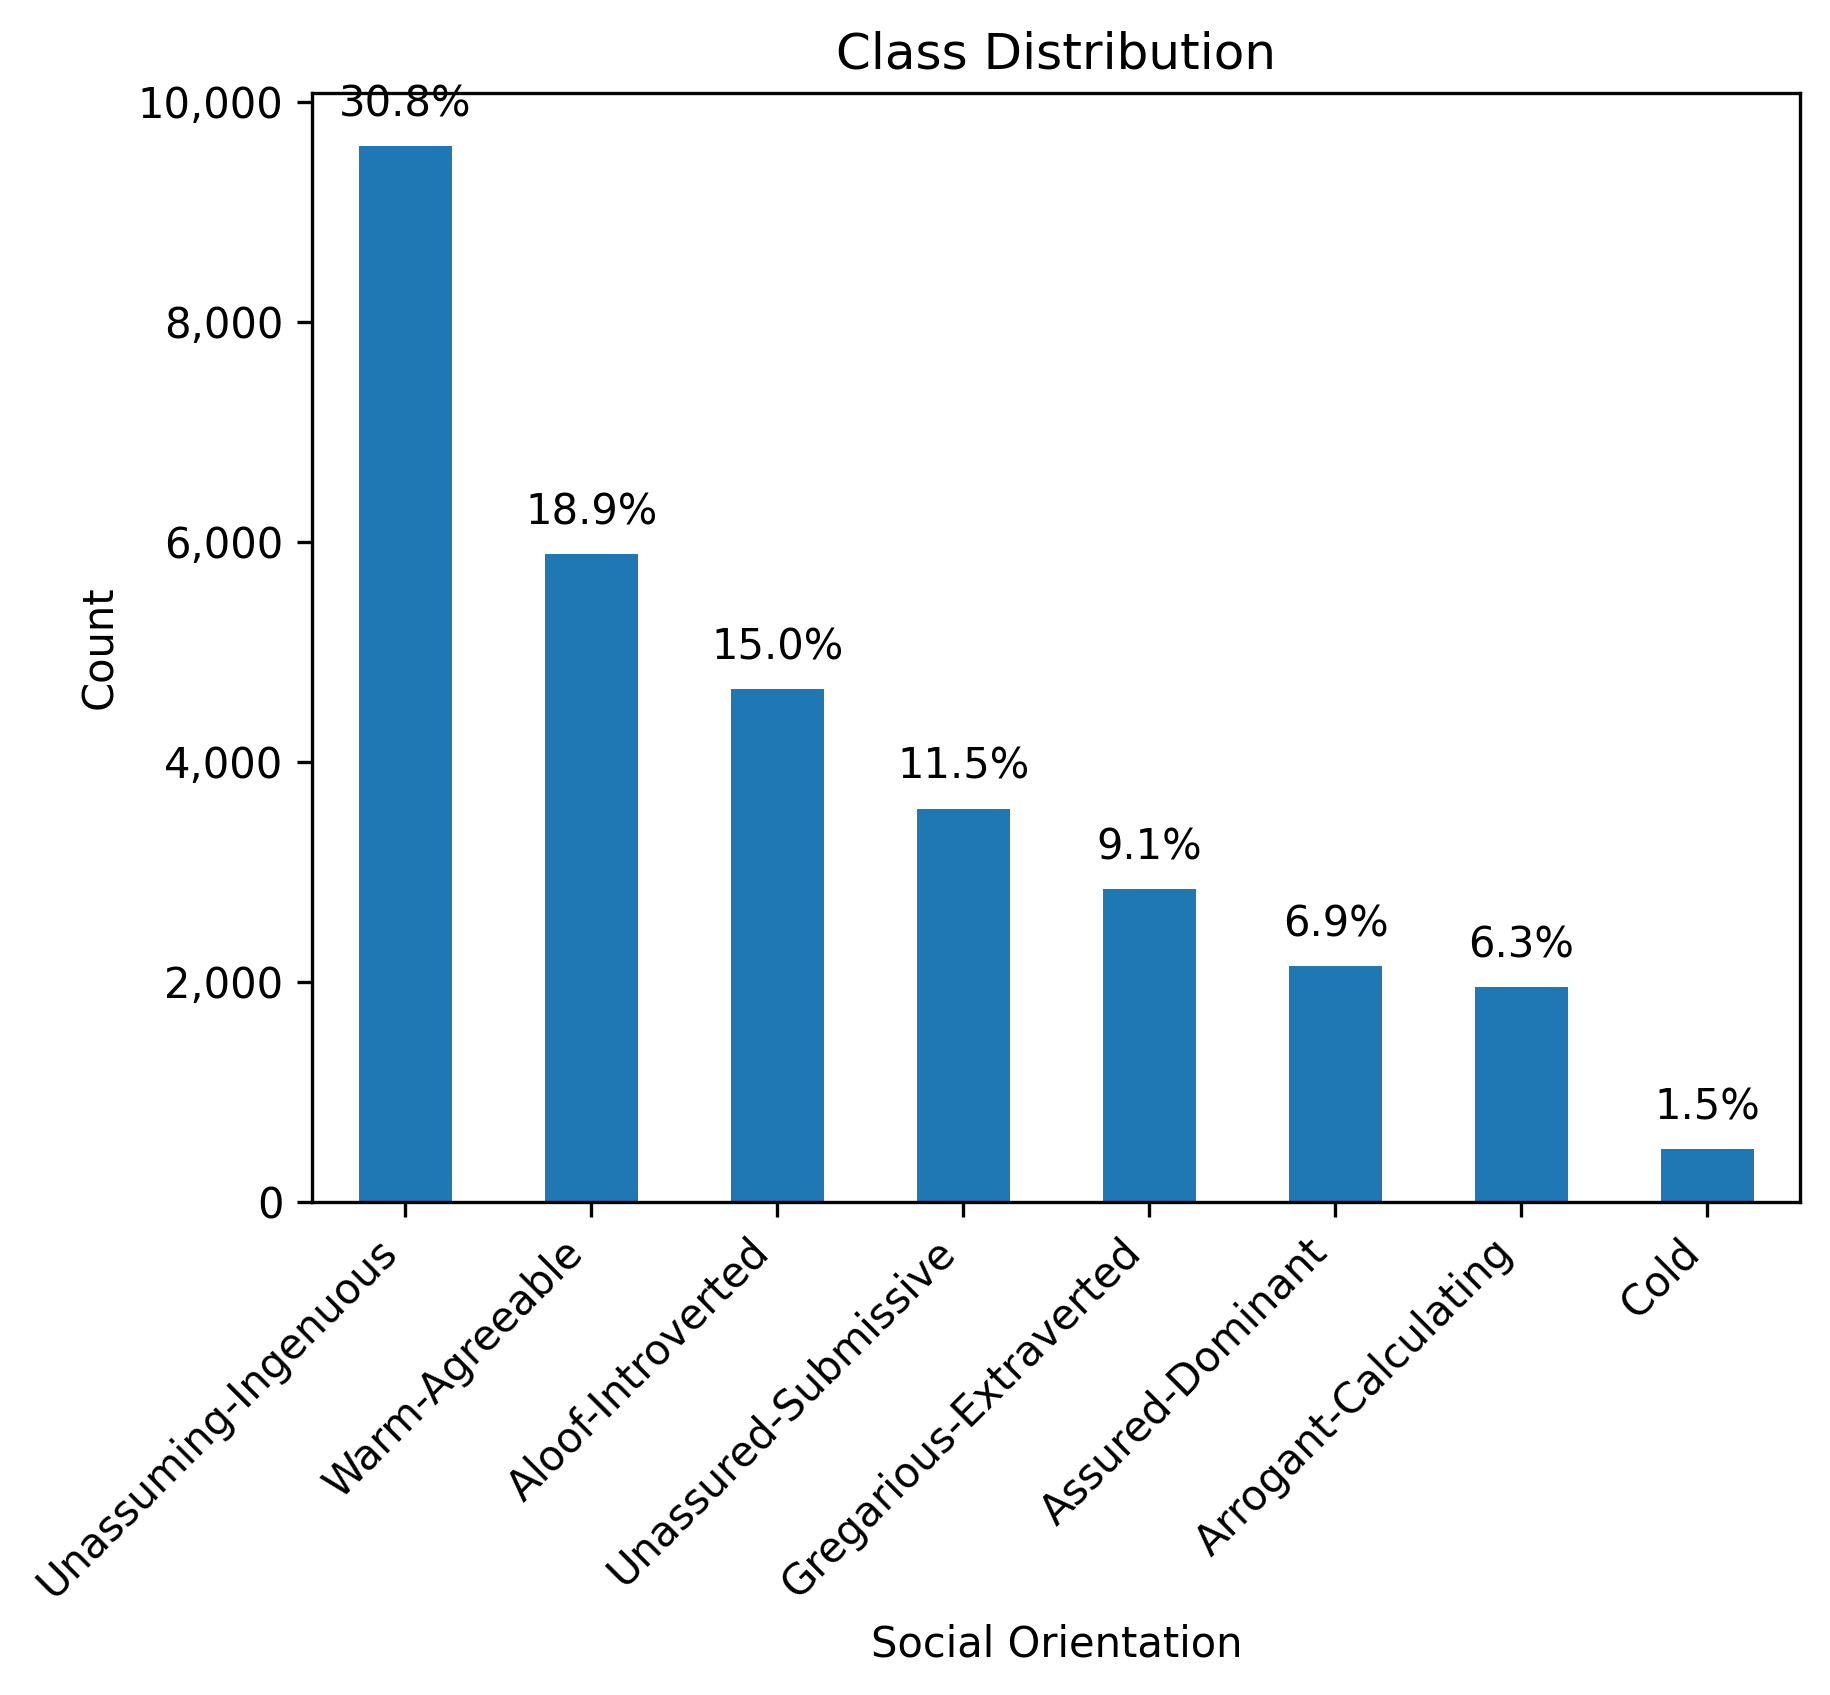

In [5]:
# plot class distribution and save to file
class_dist_filepath = os.path.join('./analysis', 'class_distribution.png')
df['social_orientation'].value_counts().plot(kind='bar')
# add percentage labels
for p in plt.gca().patches:
    plt.gca().annotate('{:.1f}%'.format(100*p.get_height()/len(df)), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution')
plt.xlabel('Social Orientation')
plt.ylabel('Count')
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig(class_dist_filepath, bbox_inches='tight')

### Evaluate against Yanda's labels

In [6]:
# load Yanda's labels
yanda_df = pd.read_csv('./analysis/M01000G9A_social_orientation.csv')

# last two rows don't contain data
yanda_df = yanda_df.iloc[:-2]

In [7]:
# accuracy
# model_2 == GPT-3.5-Turbo
(yanda_df["Yanda\'s Annotation"] == yanda_df['model_2']).sum() / len(yanda_df)

0.5294117647058824

In [8]:
# create confusion matrix
pd.crosstab(yanda_df["Yanda\'s Annotation"], yanda_df['model_2'], rownames=['Actual'], colnames=['Predicted'])

Predicted,Aloof-Introverted,Arrogant-Calculating,Assured-Dominant,Gregarious-Extraverted,Unassuming-Ingenuous,Unassured-Submissive,Warm-Agreeable
Actual,,,,,,,
Gregarious-Extraverted,0,0,0,2,5,0,2
Unassuming-Ingenuous,0,1,0,0,18,1,0
Unassured-Submissive,0,0,0,0,2,8,0
Warm-Agreeable,1,0,1,1,18,0,8


In [9]:
include_labels = list(set(yanda_df["Yanda\'s Annotation"].unique()).union(set(yanda_df['model_2'].unique())))

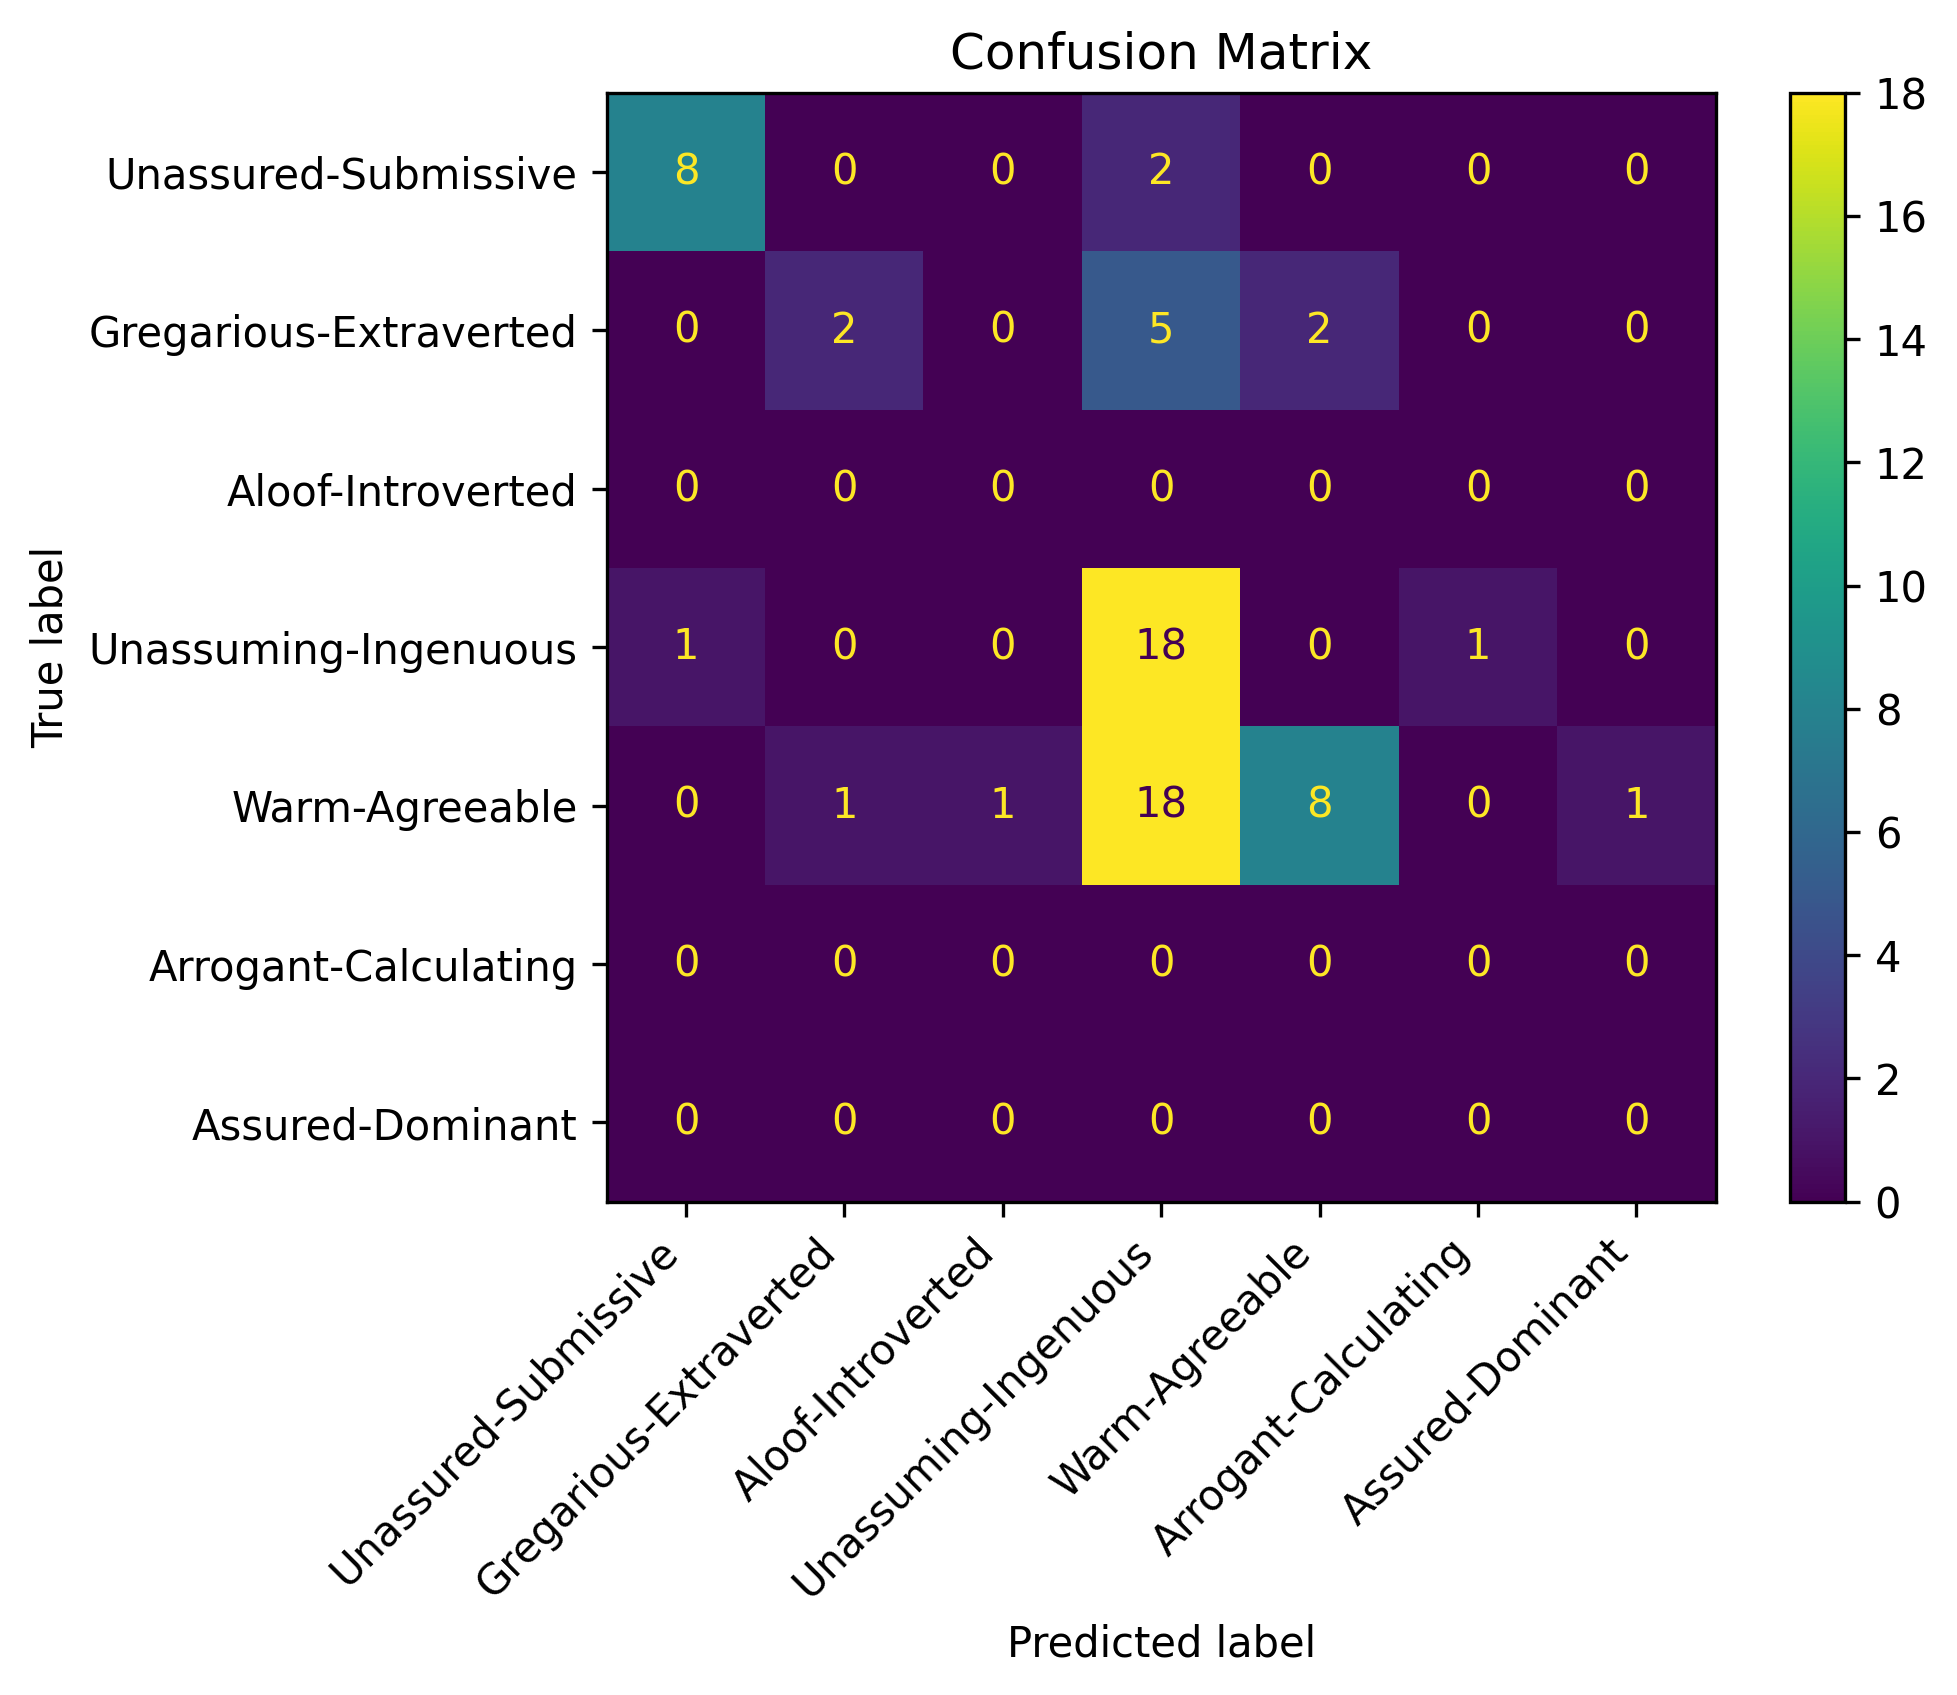

In [10]:
cm = confusion_matrix(yanda_df["Yanda\'s Annotation"], yanda_df['model_2'], labels=include_labels)

cm_display = ConfusionMatrixDisplay(cm, display_labels=include_labels).plot()
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
cm_filepath = os.path.join('./analysis', 'confusion_matrix.png')
plt.savefig(cm_filepath, bbox_inches='tight')


In [11]:
# classification report
print(classification_report(yanda_df["Yanda\'s Annotation"], yanda_df['model_2'], zero_division=0))

                        precision    recall  f1-score   support

     Aloof-Introverted       0.00      0.00      0.00         0
  Arrogant-Calculating       0.00      0.00      0.00         0
      Assured-Dominant       0.00      0.00      0.00         0
Gregarious-Extraverted       0.67      0.22      0.33         9
  Unassuming-Ingenuous       0.42      0.90      0.57        20
  Unassured-Submissive       0.89      0.80      0.84        10
        Warm-Agreeable       0.80      0.28      0.41        29

              accuracy                           0.53        68
             macro avg       0.40      0.31      0.31        68
          weighted avg       0.68      0.53      0.51        68



In [12]:
# load the model and evaluate
def get_last_checkpoint(folder):
    PREFIX_CHECKPOINT_DIR = "checkpoint"
    _re_checkpoint = re.compile(r"^" + PREFIX_CHECKPOINT_DIR + r"\-(\d+)$")
    content = os.listdir(folder)
    checkpoints = [
        path for path in content if _re_checkpoint.search(path) is not None
        and os.path.isdir(os.path.join(folder, path))
    ]
    if len(checkpoints) == 0:
        return
    return os.path.join(
        folder,
        max(checkpoints,
            key=lambda x: int(_re_checkpoint.search(x).groups()[0])))

In [13]:
model_dir = '/home/iron-man/Documents/data/charm/models/xlm-roberta-base'
last_checkpoint = get_last_checkpoint(model_dir)

In [14]:
# load trainer_state.json file to retrieve best_checkpoint
state_filepath = os.path.join(last_checkpoint,
                                'trainer_state.json')
best_model_checkpoint = utils.load_json(
    state_filepath)['best_model_checkpoint']
config_filepath = os.path.join(best_model_checkpoint, 'config.json')
config = utils.load_json(config_filepath)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(
    best_model_checkpoint).to(device)

In [15]:
tokenizer = AutoTokenizer.from_pretrained(config['_name_or_path'])

In [16]:
from charm.model.train_hf import get_circumpex_dataset

In [17]:
train_dataset, val_dataset, id2label, label2id = get_circumpex_dataset(tokenizer, os.path.split(labels_filepath)[0], 1.0)

In [18]:
collate = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
# create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate,
    drop_last=False,
    num_workers=0,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate,
    drop_last=False,
    num_workers=0,
)

In [20]:
# evaluate on validation set
model.eval()
y_true = []
y_pred = []
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    y_true.extend(batch['labels'].tolist())
    y_pred.extend(logits.argmax(dim=1).tolist())

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [21]:
label_names = []
for i in range(len(model.config.id2label)):
    label_names.append(model.config.id2label[i])

In [22]:
val_metrics_df = pd.DataFrame(classification_report(y_true, y_pred, zero_division=0, target_names=label_names, output_dict=True)).T

In [23]:
val_metrics_df.to_csv(os.path.join('./analysis', 'val_metrics.csv'))

In [24]:
print(classification_report(y_true, y_pred, zero_division=0, target_names=label_names))

                        precision    recall  f1-score   support

      Assured-Dominant       0.29      0.26      0.28       428
Gregarious-Extraverted       0.44      0.26      0.33       544
        Warm-Agreeable       0.49      0.38      0.43      1108
  Unassuming-Ingenuous       0.39      0.55      0.45      1879
  Unassured-Submissive       0.28      0.12      0.17       742
     Aloof-Introverted       0.29      0.39      0.33       937
                  Cold       0.17      0.10      0.13       111
  Arrogant-Calculating       0.27      0.19      0.22       398

              accuracy                           0.36      6147
             macro avg       0.33      0.28      0.29      6147
          weighted avg       0.36      0.36      0.35      6147



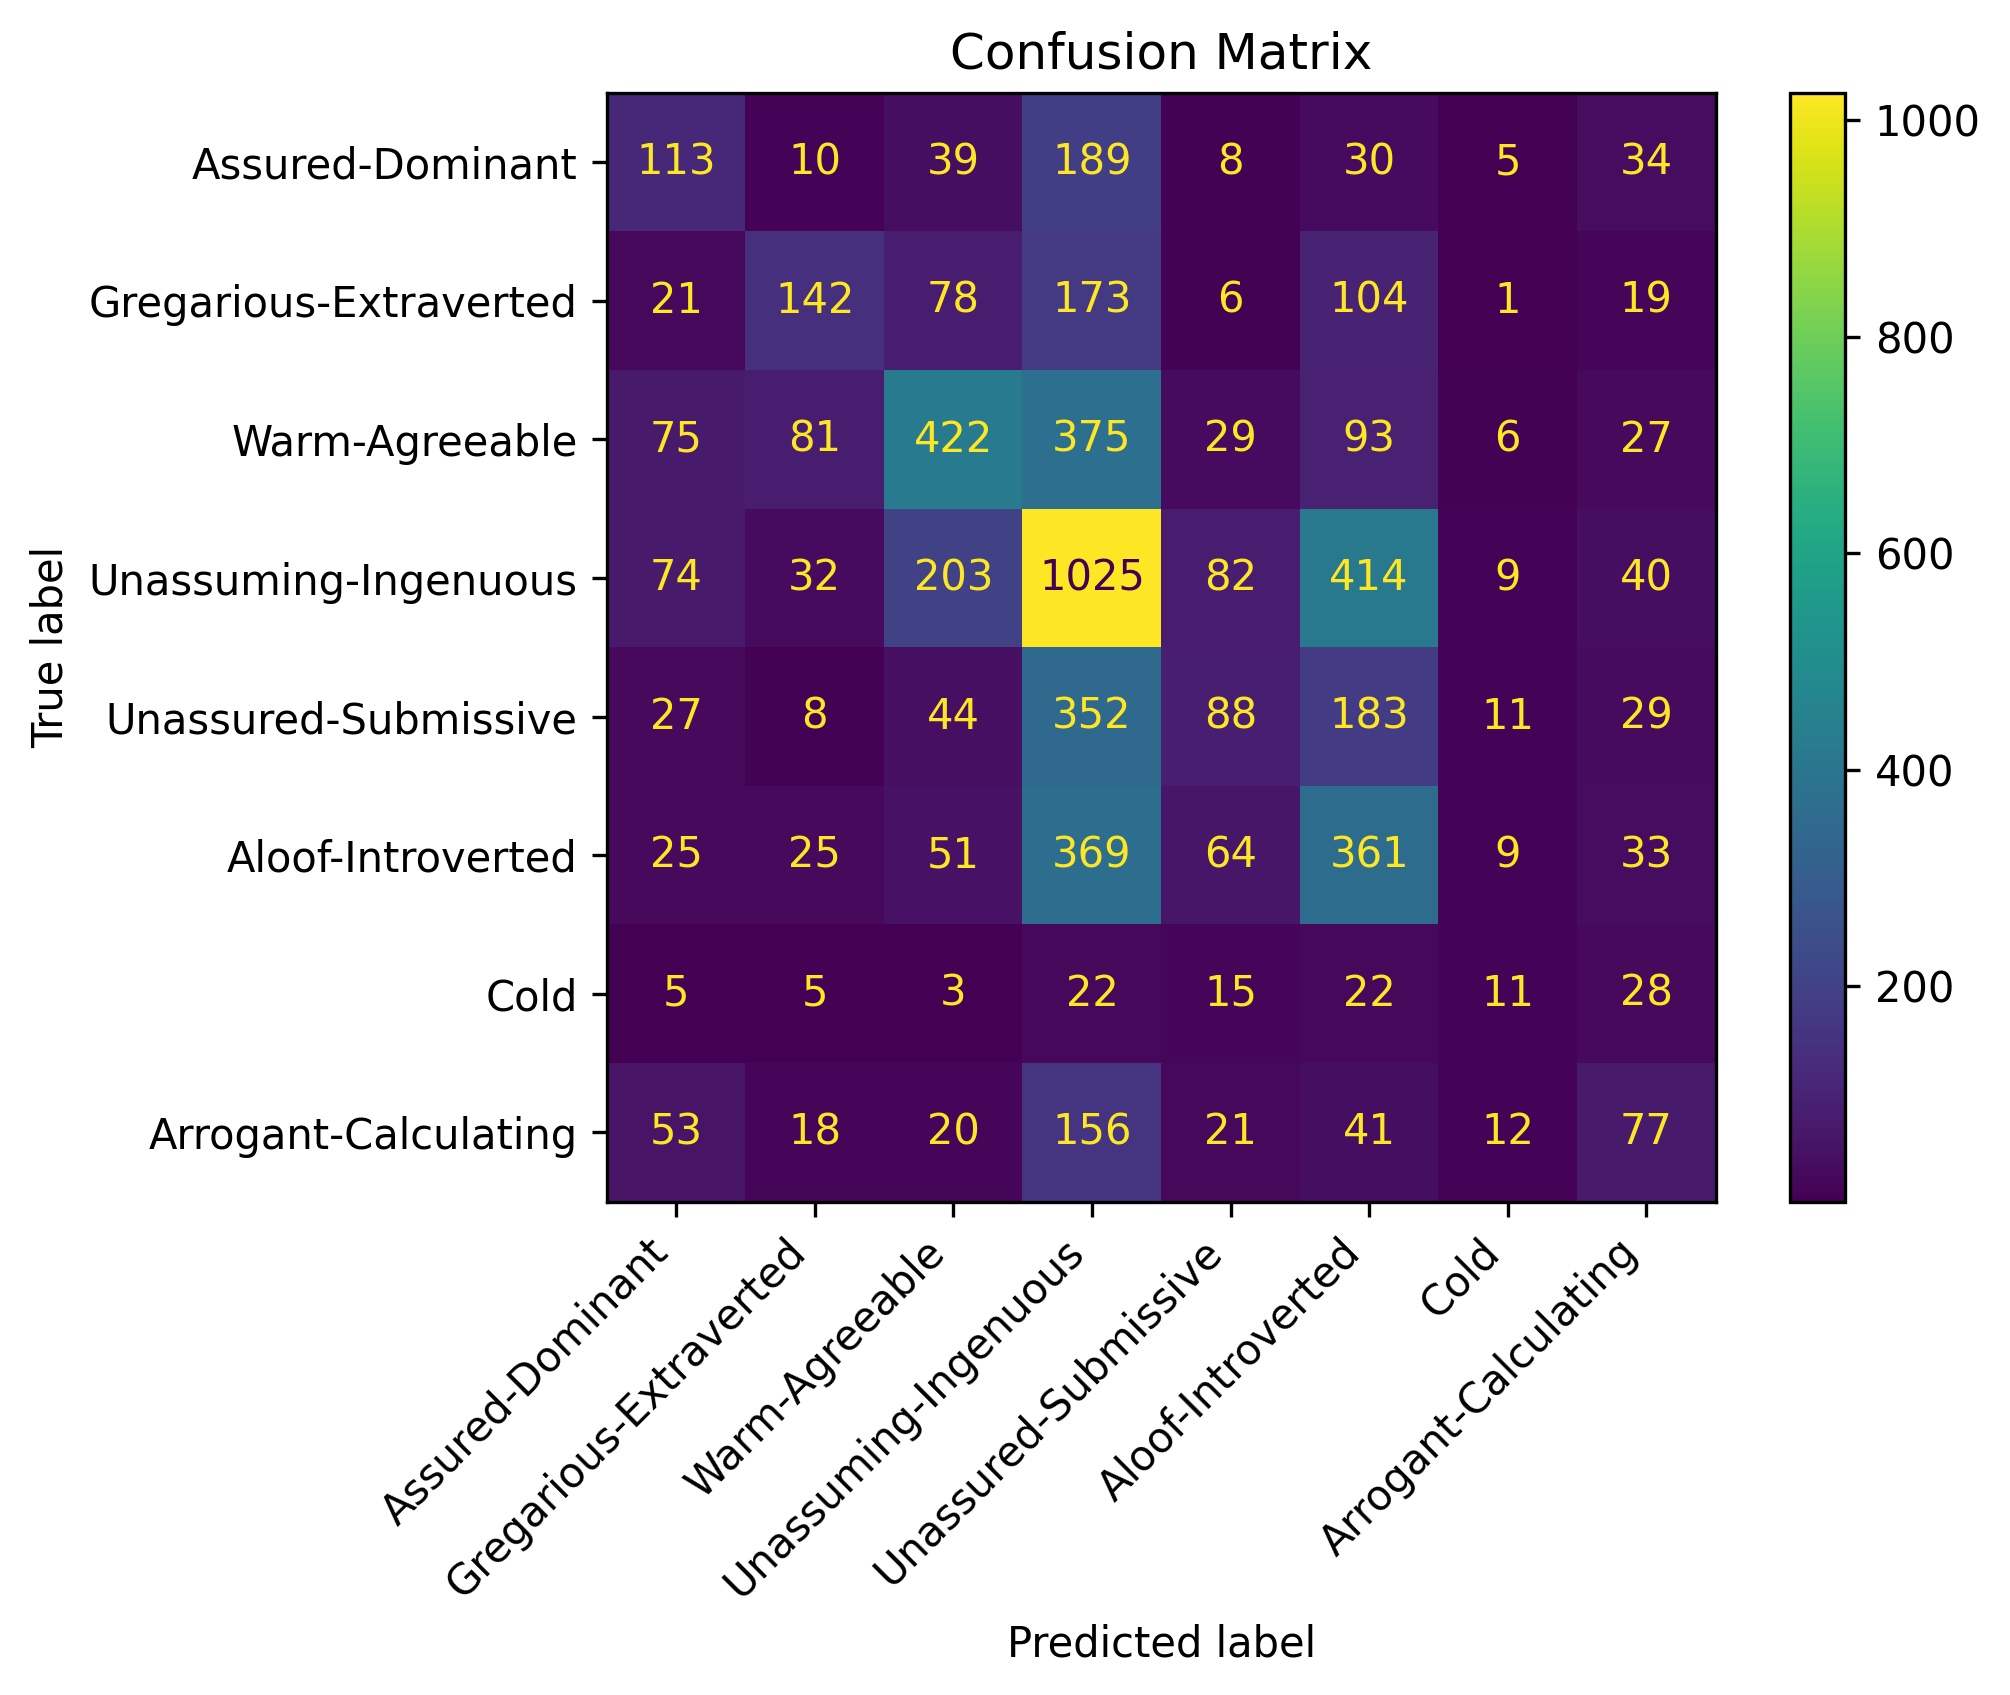

In [25]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix')
cm_filepath = os.path.join('./analysis', 'val_confusion_matrix.png')
plt.savefig(cm_filepath, bbox_inches='tight')

### Explore performance by file_id

In [26]:
val_df = val_dataset.df

In [27]:
len(val_df)

6147

In [28]:
val_df['social_orientation_prediction'] = [model.config.id2label[x] for x in y_pred]

In [29]:
# get accuracy for each file_id
val_df['correct'] = val_df['social_orientation'] == val_df['social_orientation_prediction']
file_id_accuracy = val_df.groupby('file_id')['correct'].mean().sort_values(ascending=True)

In [30]:
file_id_accuracy.iloc[:2]

file_id
M01000H3J    0.181818
M01000GTH    0.243902
Name: correct, dtype: float64

In [31]:
val_df.columns

Index(['filename', '@id', '@start_char', '@end_char', 'ORIGINAL_TEXT', '@type',
       '@begin_offset', '@char_length', 'id', 'time', 'participant', 'TOKEN',
       'social_orientation_random', 'file_id', 'timestamp', 'impact_scalar',
       'comment', 'Utterance ID', 'Complete Line', 'Complete Line Length',
       'line_len_cumsum', 'social_orientation', 'utterance_id', 'speaker_id',
       'label_str', 'label', 'input_ids', 'social_orientation_prediction',
       'correct'],
      dtype='object')

In [35]:
# get translations
from utils import translate_batch


In [36]:
translations = translate_batch(val_df[val_df['file_id'] == 'M01000H3J']['ORIGINAL_TEXT'].tolist())

Translating: 帝冠和翘楚的对不起来，你发我一个明细看看
Translating: 帝冠给你打了2.4万，付那个印刷费
Translating: [图片]翘楚和帝冠的
Translating: 看不到
Translating: 再发一遍
Translating: [图片]
Translating: 我要明细账
Translating: 我对对
Translating: 差20000呢
Translating: [图片]
Translating: 6月份帝冠一共汇来21万，6月8号有个2万，剩下的19万是汇来发工资的
Translating: .8号的收据号是多少，我查查
Translating: 你看看是和帝冠吗，还是和科技啊
Translating: 5号的，0006944，是帝冠的
Translating: 嗯，济南这边记错了
Translating: 你再看看和科技的
Translating: 和科技是413587.44
Translating: 和基地是40000
Translating: 对的
Translating: 嗯
Translating: 我把记账公司做的报表发给你看下吧
Translating: 好的
Translating: 报表说明和报表都不对应呢
Translating: 你把所有的余额表再发给我看看
Translating: 帝冠给打了2.4万，收到了，付那个印刷费就行
Translating: 这个记账公司做的报表和余额表都不对应啊
Translating: 他怎么做的
Translating: 啊，
Translating: 我看错了
Translating: 让董亮气得我
Translating: 报表说明他都没有做
Translating: 下次让他把这个也做上
Translating: 啊，那我叫他做上
Translating: 嗯
Translating: 这个月就算了
Translating: 我补上
Translating: 其他有没问题呢
Translating: 下个月记得做上
Translating: 我没看完呢，和董亮说事呢，差点被他气死
Translating: 啊，他又怎么了
Translating: 海天教育的其他应收款单位款没有明细
Translating: 你给我一下
Translating:

In [38]:
# why is M01000H3J so bad?
sample_df = val_df[val_df['file_id'] == 'M01000H3J']

In [39]:
sample_df['translation'] = translations

In [41]:
sample_df[['ORIGINAL_TEXT', 'translation', 'social_orientation', 'social_orientation_prediction', 'label_str']].to_csv('./analysis/M01000H3J.csv', encoding='utf-16')

In [72]:
# results show the GPT and the model are often directionally correct, let's try the following mapping
tone_map = {'Aloof-Introverted': 'Neutral', # negative?
 'Arrogant-Calculating': 'Negative',
 'Assured-Dominant': 'Negative',
 'Cold': 'Negative',
 'Gregarious-Extraverted': 'Positive',
 'Unassuming-Ingenuous': 'Neutral',
 'Unassured-Submissive': 'Neutral',
 'Warm-Agreeable': 'Positive'}

In [73]:
y_true_tone = [tone_map[model.config.id2label[x]] for x in y_true]
y_pred_tone = [tone_map[model.config.id2label[x]] for x in y_pred]

In [74]:
print(classification_report(y_true_tone, y_pred_tone, zero_division=0))

              precision    recall  f1-score   support

    Negative       0.45      0.36      0.40       937
     Neutral       0.70      0.83      0.76      3558
    Positive       0.61      0.44      0.51      1652

    accuracy                           0.65      6147
   macro avg       0.59      0.54      0.56      6147
weighted avg       0.64      0.65      0.64      6147

